## Astro 304 "Galaxies"

### Star formation in galaxies

In [3]:
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from code.plot_utils import plot_pretty
plot_pretty()

### SFR-$M_*$ relation of galaxies in the GAMA survey

Star formation as a function of stellar mass using the SFR estimates from the H$_\alpha$ line in the GAMA galaxy survey. The GAMA survey galaxy catalog is in the <tt>data/GAMA_DR2_master.fits</tt> file in the data folder. It was generated using <tt>data/GAMA_DR2_master_query.txt</tt> SQL query submitted on the <a href="http://www.gama-survey.org/dr2/query/index.php">GAMA DR2 server.</a> 


C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:33: RuntimeWarning: invalid value encountered in log10
C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:41: RuntimeWarning: invalid value encountered in log10


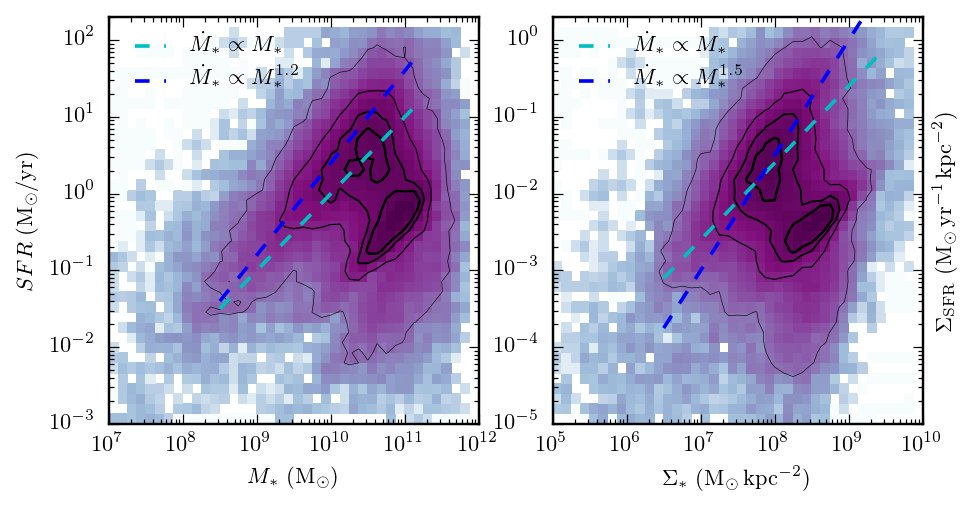

In [4]:
from code.setup import setup
import numpy as np
from code.plot_utils import plot_2d_dist, compute_inverse_Vmax
from colossus.cosmology import cosmology

def read_GAMA(fname):
    import pyfits
    hdulist = pyfits.open(fname)
    return np.asarray(hdulist[1].data)
    
data = read_GAMA(setup.data_home_dir()+"GAMA_DR2_full.fits")

cosmo = cosmology.setCosmology('WMAP9')

z_min = 0.001; z_max = 0.6
m_min = 10.5; m_max = 19.0
mpetro = data['PETROMAG_R'] - data['EXTINCTION_R']

data = data[(mpetro > m_min) & (mpetro < m_max)]; 
data = data[data['Z_HELIO'] > z_min];   
data = data[data['Z_HELIO'] < z_max]

mpetro = data['PETROMAG_R'] - data['EXTINCTION_R']
zg = data['Z_TONRY']

vmaxim = compute_inverse_Vmax(mpetro, zg, m_min=m_min, m_max=m_max, cosmomodel='WMAP9')
vmaxim = vmaxim / np.sum(vmaxim)
lMstar = data['logmstar']
Mstar = np.power(10.,lMstar)
r50 = data['GAL_RE_R']
r90 = data['GAL_R90_R']
sfr = data['SFR']
lsfr = np.log10(sfr)

# compute angular diameter distances
d_A = cosmo.luminosityDistance(zg)/cosmo.h/(1.+zg)
r50 = r50*np.pi*d_A*1000.0/(180.*3600.)
# SFR -> SFR/kpc^2, M*->Sigma_* in Msun/kpc^2
ssfr = sfr/(np.pi*r50**2)
smstar = 0.5*Mstar/(np.pi*r50**2)
lssfr = np.log10(ssfr); lsmstar = np.log10(smstar)

#
# plot SFR-M*
#

fig,ax = plt.subplots(1,2,figsize=(6, 3))
ax[0].set_xlabel(r'$M_*\ \mathrm{(M_{\odot})}$')
ax[0].set_ylabel(r'$SFR\ \mathrm{(M_\odot/yr)}$')

xmin = 1.e7; xmax = 1.e12; ymin = 1.e-3; ymax = 200.0
xlim = [np.log10(xmin), np.log10(xmax)]; ylim = [np.log10(ymin), np.log10(ymax)];

ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
ax[0].set_xscale('log'); ax[0].set_yscale('log')

nxbins = 41; nybins = 41;  clevs = np.linspace(0.2,0.95,4); 
plot_2d_dist(lMstar, lsfr, xlim, ylim,nxbins,nybins, log=True, weights=None, xlabel='x',ylabel='y', 
                 clevs=clevs, smooth=[3,2], fig_setup=ax[0], savefig=None)

# plot linear power law relations
x = np.linspace(8.5,11.2,50)
sfrlin = -2. + (x-8.)
ax[0].plot(10.**x, 10.**sfrlin,'--',c='c', lw=1.5, label=r'$\dot{M}_*\propto M_*$')

sfrpow = -2. + 1.2*(x-8.)
ax[0].plot(10.**x, 10.**sfrpow,'--',c='b', lw=1.5, label=r'$\dot{M}_*\propto M_*^{1.2}$')

ax[0].legend(frameon=False, loc='upper left',fontsize=9)

#
# now the same in the form of surface densities 
#

ax[1].set_xlabel(r'$\Sigma_*\ \mathrm{(M_{\odot}\,kpc^{-2})}$')
ax[1].set_ylabel(r'$\Sigma_{\rm SFR}\ \mathrm{(M_\odot\,yr^{-1}\, kpc^{-2})}$')

xmin = 1.e5; xmax = 1.e10; ymin = 1.e-5; ymax = 2.0
xlim = [np.log10(xmin), np.log10(xmax)]; ylim = [np.log10(ymin), np.log10(ymax)];

ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].yaxis.set_label_position('right')

plot_2d_dist(lsmstar, lssfr, xlim, ylim,nxbins,nybins, log=True, weights=None, xlabel='x',ylabel='y', 
                 clevs=clevs, smooth=[3,2], fig_setup=ax[1], savefig=None)

# plot linear power law relation
x = np.linspace(6.5,9.5,50)
sfrlin = -1.6 + (x-8.)
ax[1].plot(10.**x, 10.**sfrlin,'--',c='c', lw=1.5, label=r'$\dot{M}_*\propto M_*$')

sfrpow = -1.5 + 1.5*(x-8.)
ax[1].plot(10.**x, 10.**sfrpow,'--',c='b', lw=1.5, label=r'$\dot{M}_*\propto M_*^{1.5}$')

ax[1].legend(frameon=False, loc='upper left',fontsize=9)

#plt.savefig('fig/sfr.pdf',bbox_inches='tight')

plt.show()

### The Tully-Fisher relation

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, stats

from code.read_data import read_alfalfa
from code.read_data import read_alfalfa_sdss_crosslist
from code.read_data import alfalfa_sdss_crossmatch

# read ALFALFA data and SDSS cross-listing table
from code.setup import data_home_dir
aalist   = read_alfalfa(data_home_dir()+'a40.datafile1.txt');
sdsslist = read_alfalfa_sdss_crosslist(data_home_dir()+'a40.datafile3.txt')
# cross-match the catalogs and perform basic cuts
aatf, sdsstf = alfalfa_sdss_crossmatch(aalist, sdsslist)

# read in the relevant data from Meert et al. (2015) catalogs
from code.read_data import read_meert_catalog
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type = 3)

#
# match ALFALFA and SDSS catalogs using photoObjID
#
imatch = np.in1d(sdsstf['PhotoObjID'],sdata['objid'])
imatch2 = np.in1d(sdata['objid'],sdsstf['PhotoObjID'])
aatfmatch = aatf[imatch]; sdssmatch = sdsstf[imatch]
datamatch = sdata[imatch2]; photmatch = phot_r[imatch2]; 
mdatamatch = mdata[imatch2]; mdatagmatch = mdatag[imatch2]; 
mnpdmatch = mnpdata[imatch2]; mnpdgmatch = mnpdatag[imatch2]; 
morphmatch = morph[imatch2]

# import Benedikt Diemer's colossus package
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# extract relevand data
# redshift and log10(HI mass)
z = sdssmatch['zsdss']; lMHI = aatfmatch['logMsun']
# compute luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(z)/cosmo.h

extm = mnpdmatch['extinction']; kcorr = mnpdmatch['kcorr']
# abs. magnitude from the Meert et al. photometry using fit specified by phot_type above
# corrected for extinction, evolution, and k-correction
Mr = mdatamatch['m_tot'] - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*z - kcorr;
gr = mdatagmatch['m_tot'] - mdatamatch['m_tot']  - mnpdgmatch['extinction'] + mnpdmatch['extinction']
ur = sdssmatch['uminusr']
ba = mdatamatch['ba_tot']
cos2 = (np.power(ba,2)-0.13*0.13)/(1.0-0.13*0.13)
#sini = np.sqrt(1.0-cos2)
sini = np.sqrt((1.-np.power(ba,2))/(1-0.2**2))
# convert line width into rotation velocity (ostensibly) and correct for Doppler broadening
s = 0.5*aatfmatch['W50']/sini/(1.+z)

#
# assigned probability for galaxy to be of particular type from Huertas-Company et al. 2011 classification
#
pSab = morphmatch['probaSab']; pScd = morphmatch['probaScd']; pS0  = morphmatch['probaS0']

# maximize disks, get rid of likely S0's
pdisk = 0.7
indplot = (((pSab > pdisk) | (pScd > pdisk)) & (pS0<0.3))
Mr = Mr[indplot]; s = s[indplot]; lMHI = lMHI[indplot]
ur = ur[indplot]; gr = gr[indplot]
Lr = np.power(10.,-0.4*(Mr-4.68))
addHI = True
if addHI:
    # get the  r-band M/L ratio from color using 
    # linear mapping from (u-r) or (g-r) color from Table 7 of 
    # Bell et al. 2003, ApJS 149, 289 derived from SPS 
    #lMLr = -0.223 + 0.299*ur
    lMLr = -0.306 + 1.097*gr
    # convert Lr to stellar mass, add HI 
    Lr = np.clip(lMLr*Lr,1.e3,1.e15) + 1.4*np.power(10.,lMHI)


670722 galaxies in Meert et al. sample initially


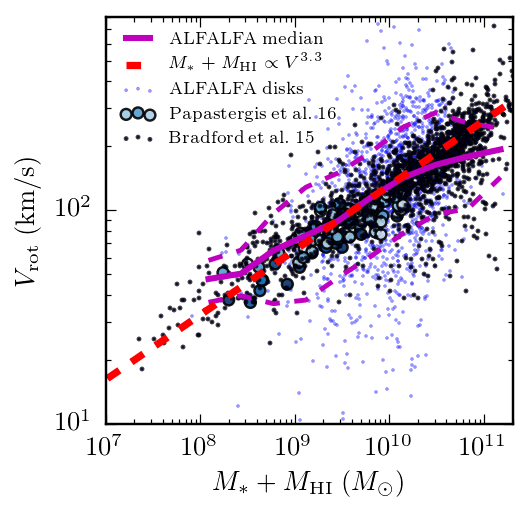

In [18]:
from matplotlib import pylab as plt

# now plot the relation
#
fig = plt.figure(figsize=(3, 3))
plt.rc('font',size=11)

if addHI:
    plt.xlabel(r'$M_*+M_{\mathrm{HI}}\ (M_{\odot})$')
else:
    plt.xlabel(r'$L_r$')
plt.ylabel(r'$V_{\rm rot}\ (\mathrm{km/s})$')
plt.ylim(10.,800.); 
plt.xlim(1.e7, 2.e11);
plt.yscale('log'); plt.xscale('log')

from scipy.stats import binned_statistic
cmed, ibedges, NMbins = binned_statistic(np.log10(Lr),s,statistic='median',bins=20)

ibins = 0.5*(ibedges[1:] + ibedges[:-1])

plt.scatter(Lr, s, marker='.', color='blue', s=0.75, alpha=0.5, label=r'$\mathrm{ALFALFA\ disks}$')
plt.plot(10.**ibins,cmed,c='m',lw=2.5, label=r'$\mathrm{ALFALFA\ median}$')

def perc84(x):
    return np.percentile(x,84.0)
def perc16(x):
    return np.percentile(x,16.0)
    
s16, ibedges, NMbins = binned_statistic(np.log10(Lr),s,statistic=perc16,bins=20)
s84, ibedges, NMbins = binned_statistic(np.log10(Lr),s,statistic=perc84,bins=20)
plt.plot(10.**ibins, s16,'--',c='m',lw=2.0)
plt.plot(10.**ibins, s84,'--',c='m',lw=2.0)

# plot the L~Vmax^a power law appropriate for a given relation
x = np.linspace(6., 12., 100)
if not addHI:
    y = 85.*10**((x-9.)/4.3); plabel = '$L\propto V^{4.3}$'
else:
    y = 65.*10**((x-9.)/3.3); plabel = '$M_*+M_{\mathrm{HI}}\propto V^{3.3}$'

plt.plot(10.**x,y,'--', c='r', lw=3.0, label=plabel)

if addHI == True:
# Papastergis et al. 2016 data
    lms, elms, lmg, elmg, lmb, elmb, vrot, evrotl, evroth, wkurt = np.loadtxt(data_home_dir()+"a_btfr.data.txt", 
                                                                              delimiter=',', 
                                                                              usecols=(1,2,3,4,5,6,7,8,9,10), 
                                                                              unpack=True)
    evrot = 0.5*(evrotl+evroth)
    nex = -3 # exclude the same outliers as Papastergis et al. 2016
    if nex == 0:
        vrot = np.log10(vrot); evrot = 0.5*np.log10((vrot + evroth)/(vrot-evrotl))
    elif nex < 0:
         lmb = lmb[:nex]; elmb = elmb[:nex]; vrot = vrot[:nex]; 
         evrot = 0.5*np.log10((vrot + evroth[:nex])/(vrot-evrotl[:nex])); wkurt = wkurt[:nex]
         vrot = np.log10(vrot)
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    cnorm  = colors.Normalize(vmin=1, vmax=22)
    scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.Blues)

    nwk = np.array((30.*(np.array(wkurt)-np.min(wkurt))/(np.max(wkurt)-np.min(wkurt))),dtype=int)
    colorg = scalarmap.to_rgba(nwk)

    plt.scatter(10.**lmb, 10.**vrot, c=colorg, s=20, alpha=0.9, label=r'$\mathrm{Papastergis\ et\ al.\ 16}$')
    
# 
# read in Bradford, Geha & Blanton M* and MHI
# 
w20b, ew20b, mbHI, embHI, mbs, embs =np.loadtxt(data_home_dir() + "bradford_etal15_table1.txt",
                                   usecols=(10,11,14,15,16,17), unpack=True)
mbHI = np.log10(mbHI) + 0.1238 + 9.0; mbs = np.log10(mbs) + 9.0
mbbar = np.power(10.,mbs) + np.power(10.,mbHI)

plt.scatter(mbbar,w20b,marker='.',c='b',s=4.,alpha=0.75, label=r'$\mathrm{Bradford\ et\ al.\ 15}$')

#

plt.legend(frameon=False, fontsize=7, loc='upper left')
plt.show()


### Metallicities of stars in galaxies

Let's construct the distribution of galaxies in the metallicity--stellar mass plane using a sample of dwarf galaxies from the study of <a href="http://adsabs.harvard.edu/abs/2006ApJ...647..970L">Lee et al. (2006)</a> (see <tt>data/lee06.txt</tt> file), and a compilation of metallicity measurements of <a href="http://adsabs.harvard.edu/abs/2013ApJ...779..102K">Kirby et al (2013)</a> (see files <tt>data/kirby11_tab2.txt</tt> <tt>data/kirby13_tab4.txt</tt>) and data from the GAMA survey. <b>This also shows you how to read in the GAMA survey data you will need as part of homework 2.</b>
The GAMA survey galaxy catalog is in the <tt>data/GAMA_DR2_master.fits</tt> file in the data folder. It was generated using <tt>data/GAMA_DR2_master_query.txt</tt> SQL query submitted on the <a href="http://www.gama-survey.org/dr2/query/index.php">GAMA DR2 server.</a> 

The plot below also shows the mean stellar mass-metallicity relation of the SDSS galaxies (<a href="http://adsabs.harvard.edu/abs/2004ApJ...613..898T">Tremonti et al. 2004</a>) with corrected calibration presented in <a href="http://www.aanda.org/component/article?access=bibcode&bibcode=&bibcode=2008A%2526A...488..463MFUL">Maiolino et al. (2008)</a>.

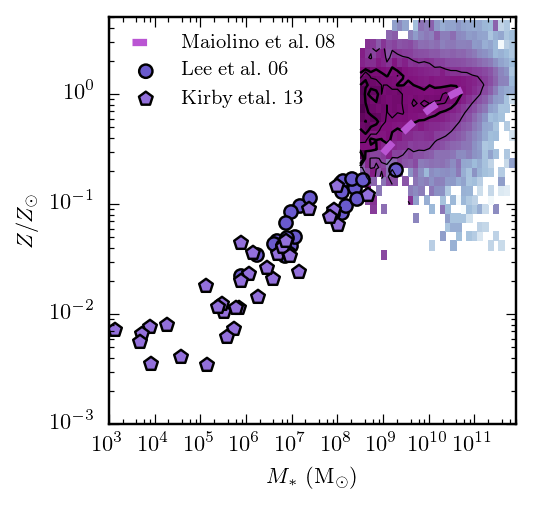

In [8]:
from code.setup.setup import data_home_dir

plot_pretty()

fig = plt.figure(figsize=(3, 3))
ylabel = r'$Z/Z_\odot$'; xlabel = r'$M_{*}\ \rm (M_\odot)$'
xlims = [1.e3, 8.e11]; ylims = [1.e-3,  5.]
plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.xscale('log'); plt.yscale('log')
plt.xlim(xlims); plt.ylim(ylims)

#
# plot observational trend from Maiolino
OHsol = 9.
    
def Zmaiolino08(lMs,lM0,K0):
    """
    best fit relation from table in Maiolino et al. 2008 using consistent Z calibration
    """
    return -0.0864*(lMs-lM0)**2 + K0

zcolors = ['mediumorchid', 'red', 'blue', 'darkgray']
zmaio = np.array([0.07,  2.2, 3.5])
lM0 = np.array([11.8, 12.38, 12.76])
K0 = np.array([9.04, 8.99, 8.79])
nzplot = 1

lMs = np.arange(9.0, 11.0, 0.1)
for i, zm in enumerate(zmaio[:nzplot]): 
    Zmaio = Zmaiolino08(lMs, lM0[i], K0[i]) - OHsol + 0.1
    if i == 0:
        plt.plot(10.**lMs, 10.**Zmaio, '--', c=zcolors[i], lw=3.0, label=r'$\rm Maiolino\ et\ al.\ 08$')
    else:
        plt.plot(10.**lMs, 10.**Zmaio, '--', c=zcolors[i], lw=3.0)

#
# plot GAMA data
#


def plot_GAMA():
    def read_GAMA(fname):
        import pyfits
        hdulist = pyfits.open(fname)
        return np.asarray(hdulist[1].data)
    
    #data = read_GAMA(data_home_dir()+"GAMA_AEAtSz.fits")
    data = read_GAMA(data_home_dir()+"GAMA_DR2_full.fits")
 
    z_min = 0.001
    z_max = 0.35
    m_min = 10.5
    m_max = 19.
 
    data = data[data['GAL_MAG_R'] < m_max]; 
    data = data[data['GAL_MAG_R'] > m_min]; 
    data = data[data['Z_HELIO'] > z_min];   
    data = data[data['Z_HELIO'] < z_max]
 
    vmaxi = compute_inverse_Vmax(data['GAL_MAG_R'], data['Z_HELIO'], m_min, m_max)
    vmaxnorm = np.sum(vmaxi)
    vmaxi /= vmaxnorm
    Z = data['metal']/0.0126 # normalize to solar according to Asplund et al. (2004)
    lZ = np.log10(Z)
    lMstar = data['logmstar']
    Mstar = np.power(10.,lMstar)
    clevs = np.linspace(0.2,0.95,4)
    
    import scipy.optimize as opt
    from matplotlib.colors import LogNorm
 
    def conf_interval(x, pdf, conf_level):
        return np.sum(pdf[pdf > x])-conf_level
 
    #
    H, xbins, ybins = np.histogram2d(lMstar, lZ, weights=vmaxi, bins=(np.linspace(8.5, 12., 31), np.linspace(-1.5, 1.0, 31)))
 
    H = np.rot90(H)
    H = np.flipud(H)
    Hmask = np.ma.masked_where(H==0,H)
    H = H/np.sum(H)        
             
    xbins = 10.**xbins; ybins = 10.**ybins
    X,Y = np.meshgrid(xbins[:-1],ybins[:-1]) 
 
    clevs = np.linspace(0.2,0.95,4)
    lvls = []
    for cld in clevs:  
        sig = opt.brentq( conf_interval, 0., 1., args=(H,cld) )  
        lvls.append(sig)
        
    #plt.scatter(10.**lMstar, 10.**lZ, c='m', s=0.85, alpha=0.5)
    plt.pcolor(X,Y,(Hmask),cmap=plt.cm.BuPu, norm = LogNorm(), label='GAMA',rasterized=True)
    plt.contour(X,Y,(H), linewidths=(1.0,0.5), colors='black', levels = lvls, norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])


plot_GAMA()

# plot Lee et al. 2006
lMsL = np.linspace(5.5, 9.5, 100)
lZLp, elZLp, lMsLp = np.loadtxt(data_home_dir()+"lee06.txt",usecols=(1,3,4),unpack=True)
lZLp = lZLp - OHsol
plt.scatter(10**lMsLp,10.**lZLp, s=30, marker='o', c='slateblue', label=r'$\rm Lee\ et\ al.\ 06$')
lLVk, elLVk, lZk, elZk  = np.loadtxt(data_home_dir()+"kirby13_tab4.txt",usecols=(4,5,6,7),unpack=True)
plt.scatter(10**lLVk, 10.**lZk, s=35, marker='p', c='mediumpurple', label=r'$\rm Kirby\ et al.\ 13$')

plt.legend(frameon=False, loc='upper left', scatterpoints=1, fontsize=8)
#plt.grid()
#plt.savefig('fig/MsZ.pdf', bbox_inches='tight')
plt.show()
